#「自宅外就業者・通学者数」が全体の人流に相関していると信じて……

matrix([[8145783],
        [2924335],
        [2501459],
        [3806212]])
17377789
pf:
matrix([[0.66590075, 0.04820275, 0.0330631 , 0.06261186],
        [0.11491897, 0.93274915, 0.01721955, 0.00738556],
        [0.08800652, 0.01424871, 0.94374803, 0.00682201],
        [0.13117376, 0.00479938, 0.00596932, 0.92318058]])
pf inverse:
matrix([[ 1.54252883e+00, -7.83882763e-02, -5.19550993e-02,
         -1.03606181e-01],
        [-1.85751215e-01,  1.08188062e+00, -1.32578896e-02,
          4.04079297e-03],
        [-1.39468788e-01, -9.06464166e-03,  1.06464585e+00,
          1.66416750e-03],
        [-2.17308822e-01,  5.57229736e-03,  5.67134598e-04,
          1.09790122e+00]])


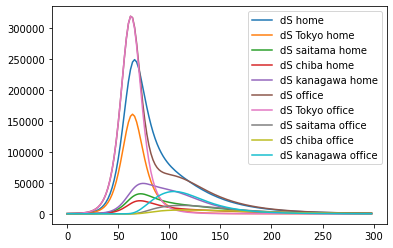

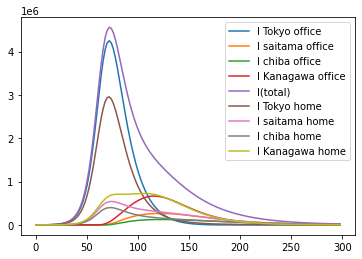

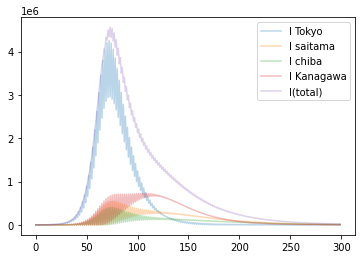

In [6]:
import numpy as np
import pprint

#N=36810107 # 人口動態調査(2020年1月1日時点)によると、東京圏(東京、埼玉、千葉、神奈川)の人口は3675万4193人だった

#S=[np.matrix([[13971109], # 東京 (推計人口2021年4月1日)
#             [7343453], # 埼玉
#             [6281394], # 千葉
#             [9214151]])]# 神奈川
I=[np.matrix([[708], #  東京
             [198], # 埼玉
             [148], # 千葉
             [222]])]# 神奈川
R=[np.matrix([[0], #  東京
             [0], # 埼玉
             [0], # 千葉
             [0]])]# 神奈川
dS=[]
dI=[]
dR=[]



#H27自宅外就業者・通学者数
#,              （従業・通学都道府県）
#（常住都道府県）, 東京都, 埼玉県, 千葉県, 神奈川県
#東京都, 5424283, 140961, 82706, 238314
#埼玉県, 936105, 2727671, 43074, 28111
#千葉県, 716882, 41668, 2360747, 25966
#神奈川県, 1068513, 14035, 14932, 3513821

#都道府県i→都道府県jの通勤通学人口(全人口が朝に出て，夕方に戻ると仮定)
population_flow=np.matrix(
    [[5424283, 140961, 82706, 238314],#東京→東京, 東京→埼玉, 東京→千葉, 東京→神奈川
    [936105, 2727671, 43074, 28111],
    [716882, 41668, 2360747, 25966],
    [1068513, 14035, 14932, 3513821]]
)

S=[np.concatenate((
        population_flow[:,0].sum(axis=0), # 東京 (推計人口2021年4月1日)
        population_flow[:,1].sum(axis=0), # 埼玉
        population_flow[:,2].sum(axis=0), # 千葉
        population_flow[:,3].sum(axis=0), # 神奈川
),axis=0)]
pprint.pprint(S[0])

N=S[0].sum(axis=0)[0,0]

gamma=1/14 #回復率．（γ=1/感染者の回復日数とすることができるらしいので．回復日数を14日として）
R0=5 #実効再生産数
beta0=R0*gamma#R0=beta0/gamma (定義より)
beta=beta0/N

pf=population_flow
pf=np.concatenate((
        pf[:,0]/pf[:,0].sum(axis=0),
        pf[:,1]/pf[:,1].sum(axis=0),
        pf[:,2]/pf[:,2].sum(axis=0),
        pf[:,3]/pf[:,3].sum(axis=0),
),axis=1)
pf2=np.linalg.inv(pf)

print("pf:")
pprint.pprint(pf)
print("pf inverse:")
pprint.pprint(pf2)


#pf2=population_flow+population_flow.T
#pf2=np.concatenate((
#        pf2[:,0]/pf2[:,0].sum(axis=0),
#        pf2[:,1]/pf2[:,1].sum(axis=0),
#        pf2[:,2]/pf2[:,2].sum(axis=0),
#        pf2[:,3]/pf2[:,3].sum(axis=0),
#),axis=1)

#pprint.pprint(beta)

T = range(0,300,2)#step=2

for t in T:
    #print("t="+str(t))
    #pprint.pprint(S[t])

    #出勤と出勤後の感染
    S.append(np.matmul(pf,S[t]))#S[t+1]=
    I.append(np.matmul(pf,I[t]))#I[t+1]=
    R.append(R[t])#Rは面倒くさいので移動させない

    contacts=np.multiply(S[t+1],I[t+1])
    #pprint.pprint(I[t])
    dS.append(-beta*contacts)#dS[t]
    S[t+1]=S[t+1] + dS[t]
    #dR = 0
    #R[t+1]=R[t+1] + dR
    
    dI = -dS[t]
    I[t+1]=I[t+1] + dI

    #帰りと帰った後の感染
    S.append(np.matmul(pf2,S[t+1]))#S[t+2]=
    I.append(np.matmul(pf2,I[t+1]))#I[t+2]=

    contacts=np.multiply(S[t+2],I[t+2])
    dS.append(-beta*contacts)#dS[t+1]=
    S[t+2]=S[t+2] + dS[t+1]
    dR = gamma*I[t+2]
    dI = -dS[t+1] - dR
    I[t+2]=I[t+2] + dI

    I[t+2]=I[t+2] + dI
    for i in range(0,4):
        if(I[t+2][i,0]<0):
            I[t+2][i,0]=0
    #pprint.pprint(I[t+2])


    R.append(R[t+1] + dR)
    #pprint.pprint(S[t+2])


ds={}
ds["tokyo"]=[]
ds["saitama"]=[]
ds["chiba"]=[]
ds["kanagawa"]=[]
ds["sum"]=[]
s={}
s["tokyo"]=[]
s["saitama"]=[]
s["chiba"]=[]
s["kanagawa"]=[]
s["sum"]=[]
i={}
i["tokyo"]=[]
i["saitama"]=[]
i["chiba"]=[]
i["kanagawa"]=[]
i["sum"]=[]
r=[]


for t in range(0,300,1):
    s["tokyo"].append(S[t][0,0])
    s["saitama"].append(S[t][1,0])
    s["chiba"].append(S[t][2,0])
    s["kanagawa"].append(S[t][3,0])
    s["sum"].append(S[t].sum())

    ds["tokyo"].append(-dS[t][0,0])
    ds["saitama"].append(-dS[t][1,0])
    ds["chiba"].append(-dS[t][2,0])
    ds["kanagawa"].append(-dS[t][3,0])
    ds["sum"].append(-dS[t].sum())

    i["tokyo"].append(I[t][0,0])
    i["saitama"].append(I[t][1,0])
    i["chiba"].append(I[t][2,0])
    i["kanagawa"].append(I[t][3,0])
    i["sum"].append(I[t].sum())

    r.append(R[t].sum())

x = range(0,300,2)
from matplotlib import pyplot
#pprint.pprint(ds["sum"])
pyplot.plot(x,ds["sum"][0::2],label="dS home")
pyplot.plot(x,ds["tokyo"][0::2],label="dS Tokyo home")
pyplot.plot(x,ds["saitama"][0::2],label="dS saitama home")
pyplot.plot(x,ds["chiba"][0::2],label="dS chiba home")
pyplot.plot(x,ds["kanagawa"][0::2],label="dS kanagawa home")
pyplot.plot(x,ds["sum"][1::2],label="dS office")
pyplot.plot(x,ds["tokyo"][1::2],label="dS Tokyo office")
pyplot.plot(x,ds["saitama"][1::2],label="dS saitama office")
pyplot.plot(x,ds["chiba"][1::2],label="dS chiba office")
pyplot.plot(x,ds["kanagawa"][1::2],label="dS kanagawa office")
pyplot.legend()
pyplot.show()


#pyplot.plot(x,s["sum"],label="S(sum)")
#pyplot.plot(x,s["tokyo"],label="S Tokyo")
#pyplot.plot(x,s["saitama"],label="S saitama")
#pyplot.plot(x,s["chiba"],label="S chiba")
#pyplot.plot(x,s["kanagawa"],label="S kanagawa")
pyplot.plot(x,i["tokyo"][0::2],label="I Tokyo office")
pyplot.plot(x,i["saitama"][0::2],label="I saitama office")
pyplot.plot(x,i["chiba"][0::2],label="I chiba office")
pyplot.plot(x,i["kanagawa"][0::2],label="I Kanagawa office")
pyplot.plot(x,i["sum"][1::2],label="I(total)")
pyplot.plot(x,i["tokyo"][1::2],label="I Tokyo home")
pyplot.plot(x,i["saitama"][1::2],label="I saitama home")
pyplot.plot(x,i["chiba"][1::2],label="I chiba home")
pyplot.plot(x,i["kanagawa"][1::2],label="I Kanagawa home")
#pyplot.plot(x,r,label="R")
pyplot.legend()
pyplot.show()

x = range(0,300,1)
pyplot.plot(x,i["tokyo"],label="I Tokyo", alpha=0.3)
pyplot.plot(x,i["saitama"],label="I saitama", alpha=0.3)
pyplot.plot(x,i["chiba"],label="I chiba", alpha=0.3)
pyplot.plot(x,i["kanagawa"],label="I Kanagawa", alpha=0.3)
pyplot.plot(x,i["sum"],label="I(total)", alpha=0.3)
#pyplot.plot(x,r,label="R")
pyplot.legend()
pyplot.show()
